In [1]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import pandas as pd
import copy
import math
from einops import rearrange
from einops.layers.torch import Rearrange
import time
import random
import h5py
import webdataset as wds
import gc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import utils
from models import get_vit
import nibabel as nib
from nilearn import plotting

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

num_devices = os.getenv('NUM_GPUS')
if num_devices is None: 
    num_devices = 1
else:
    num_devices = int(num_devices)
print("NUM GPUS ", num_devices)
distributed = True if num_devices>1 else False

world_size = os.getenv('COUNT_NODE')
if world_size is None: 
    world_size = 1
else:
    world_size = int(world_size)
print("WORLD_SIZE ", world_size)

if utils.is_interactive():
    # Following allows you to change functions in models.py or utils.py and 
    # have this notebook automatically update with your revisions
    %load_ext autoreload
    %autoreload 2
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

# Load parameters from yaml config
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)

# create global variables from the config
for attribute_name in config.keys():
    globals()[attribute_name] = config[f'{attribute_name}']

data_type = torch.float16 # change depending on your mixed_precision
batch_size = global_batch_size // num_devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

LOCAL RANK  0
NUM GPUS  1
WORLD_SIZE  1
PID of this process = 3117839
device = cuda distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configuration

In [2]:
print(config)

# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../ckpts/{model_name}')
os.makedirs(outdir,exist_ok=True)
print("outdir", outdir)

if use_contrastive_loss:
    global_batch_size = global_batch_size // 2 # contrastive loss doubles the batch size with the same samples and different masks
print("global_batch_size", global_batch_size)

use_cls_token = True if use_contrastive_loss else use_cls_token
print("use_cls_token", use_cls_token)

num_patches = int(
    (img_size[0] / patch_size)
    * (img_size[1] / patch_size)
    * (img_size[2] / patch_size)
    * num_frames
)
num_patches_per_timepoint = num_patches // num_frames
num_encoder_patches = int(num_patches_per_timepoint * (1 - tube_start_masking_ratio) * num_frames)
num_decoder_patches = int(num_patches_per_timepoint * (1 - decoder_mask_ratio) * num_frames)
print("num_patches", num_patches)
print("num_encoder_patches", num_encoder_patches)
print("num_decoder_patches", num_decoder_patches)

{'model_name': 'ViTB_means_newdl_ridgeEmb', 'use_cls_token': False, 'use_contrastive_loss': False, 'constrastive_loss_weight': 1.0, 'global_batch_size': 8, 'num_workers': 4, 'num_epochs': 150, 'seed': 42, 'max_lr': 3e-05, 'num_samples_per_epoch': 1024, 'ckpt_saving': False, 'ckpt_interval': 50, 'resume_from_ckpt': False, 'wandb_log': True, 'tube_start_masking_ratio': 0.9, 'tube_end_masking_ratio': 0.9, 'decoder_mask_ratio': 0.9, 'encoder_model': 'vit_base', 'decoder_model': 'vit_base', 'patch_size': 8, 'frame_patch_size': 1, 'use_rope_emb': False, 'masking_strategy': 'MNI', 'img_size': [88, 104, 72], 'num_frames': 4, 'train_urls': '/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/wds_creation/wds/{000000..000382}.tar'}
outdir /weka/proj-fmri/paulscotti/fMRI-foundation-model/ckpts/ViTB_means_newdl_ridgeEmb
global_batch_size 8
use_cls_token False
num_patches 5148
num_encoder_patches 514
num_decoder_patches 514


# Prep models

In [3]:
# Initialize list to keep track of session_ids to use with nn.Embedding
session_ids = []
def get_or_append_session_id(new_ids,device=device):
    indices = []
    for id in new_ids:
        if id not in session_ids:
            session_ids.append(id)
        indices.append(session_ids.index(id))
    return torch.tensor(indices).to(device)
# print(get_or_append_session_id(["0001", "33", "42"]))
# print(get_or_append_session_id(["2", "33"]))

In [8]:
vit_size = {
    "encoder": encoder_model,
    "decoder": decoder_model
}
    
model = get_vit(
    size=vit_size,
    image_size=img_size,  # depth, height, width
    image_patch_size=(patch_size,patch_size,patch_size),  # depth, height, width patch size
    frames=num_frames,
    frame_patch_size=frame_patch_size,
    channels=1,
    use_rope_emb=use_rope_emb,
    use_cls_token=use_cls_token,
)
utils.count_params(model)

# function to select random num_frames from sample and obtain brain-positive patches
aug_transform = utils.DataPrepper(
    num_frames=num_frames,
    masking_strategy=masking_strategy,
    patch_depth=patch_size,
    patch_height=patch_size,
    patch_width=patch_size,
    frame_patch_size=frame_patch_size,
)

# test that the model works without error
model = model.to(device)
encoder_mask = torch.zeros(num_patches).to(device).to(torch.bool)
encoder_mask[:num_encoder_patches] = True
decoder_mask = torch.zeros(num_patches).to(device).to(torch.bool)
decoder_mask[-num_decoder_patches:] = True
with torch.no_grad():
    print("\nencoder")
    encoder_out = model(
                torch.randn(6, 1, num_frames, img_size[0], img_size[1], img_size[2]).to(device),
                encoder_mask=encoder_mask,
                verbose=True)
    print("\ndecoder")
    decoder_out = model(
                encoder_out, 
                encoder_mask=encoder_mask, 
                decoder_mask=decoder_mask, 
                verbose=True)
    if use_cls_token:
        enc_cls_token = encoder_out[:, :1, :]
        encoder_patches = encoder_out[:, 1:, :]
        dec_cls_token = decoder_out[:, :1, :]
        decoder_patches = decoder_out[:, 1:, :]
        print("\nenc_cls_token", enc_cls_token.shape)
        print("encoder_patches", encoder_patches.shape)
        print("dec_cls_token", dec_cls_token.shape)
        print("decoder_patches", decoder_patches.shape)

param counts:
171,420,672 total
171,420,672 trainable

encoder
created zero ids tensor([0, 0, 0, 0, 0, 0], device='cuda:0')
torch.Size([6, 1, 4, 88, 104, 72])
patched torch.Size([6, 4, 11, 13, 9, 512])
patched_emb torch.Size([6, 4, 11, 13, 9, 768])
reshaped torch.Size([6, 5148, 768])
nn.Embedding
pe torch.Size([5148, 768])
x torch.Size([6, 5148, 768])
masked torch.Size([6, 514, 768])
torch.Size([6, 514, 768])

decoder
torch.Size([6, 514, 768])
pe torch.Size([5148, 768])
pos_emd_encoder torch.Size([514, 768])
pos_emd_decoder torch.Size([514, 768])
x_concat torch.Size([6, 1028, 768])
torch.Size([6, 1028, 768])
proj torch.Size([6, 1028, 512])


## Create dataset and data loaders

In [10]:
from dataloader import create_dataset, create_loader

In [11]:
print(train_urls)

train_dp = create_dataset(train_urls, 
                          is_s3=train_urls[:2]=="s3", 
                          sample_shuffle=100, shard_shuffle=100)
train_dl = create_loader(train_dp, batch_size=batch_size, num_workers=num_workers)

/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/wds_creation/wds/{000000..000382}.tar
Adding decoder ImageHandler to decoders.
####################################################################################################
Building dataloader with the following parameters
batch_size: 8, num_workers: 4
####################################################################################################


### Check data loaders work

In [12]:
num_it = 2
print(f"Yielding {num_it} batches")

for i, batch in enumerate(train_dl):
    print("iter",i)
    input_func = batch['func.npy']
    if i >= (num_it-1):
        break

print("Done!")
print("input_func", input_func.shape)

Yielding 2 batches
iter 0
iter 1
Done!
input_func torch.Size([8, 32, 88, 104, 72])


# Playing with the data, visualization of patching + masking

In [13]:
# func, brain_pos_pats = aug_transform(input_func)
# print(func.shape)
# utils.view_brain()

In [14]:
if masking_strategy=="MNI":
    MNI_brain = nib.load("/weka/proj-fmri/paulscotti/old_fMRI-foundation-model/dataset_creation/afni_conversion/tpl-MNI152NLin2009cAsym_res-02_T1w_brain.nii.gz").get_fdata()
    brain_pos_voxels = MNI_brain[6:94,8:112,10:82]
    brain_pos_pats = model.patchify(torch.Tensor(brain_pos_voxels)[None,None,None])
    brain_pos_pats_vit = rearrange(brain_pos_pats, "b ... d -> b (...) d").mean(-1)[0]

func torch.Size([8, 1, 4, 88, 104, 72])
patches torch.Size([8, 4, 11, 13, 9, 512])
patches_vit torch.Size([8, 5148, 512])
num patches in one timepoint 1287
Percentage of brain positive patches 0.5633255633255633
num tube patches = 128
tube mask percent 0.09945609945609946
num decoder patches = 128
decoder_mask percent 0.09945609945609946
tube_unpatches torch.Size([8, 4, 11, 13, 9, 512])
decoder_unpatches torch.Size([8, 4, 11, 13, 9, 512])
encoder_func torch.Size([8, 1, 4, 88, 104, 72])
decoder_func torch.Size([8, 1, 4, 88, 104, 72])
original func


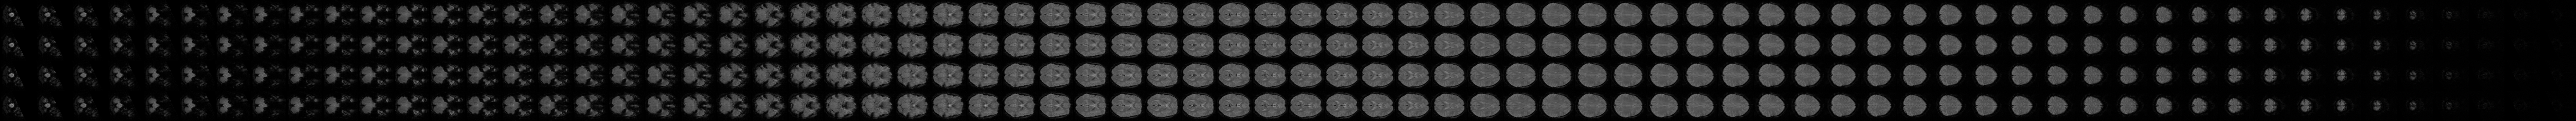


brain-positive patches


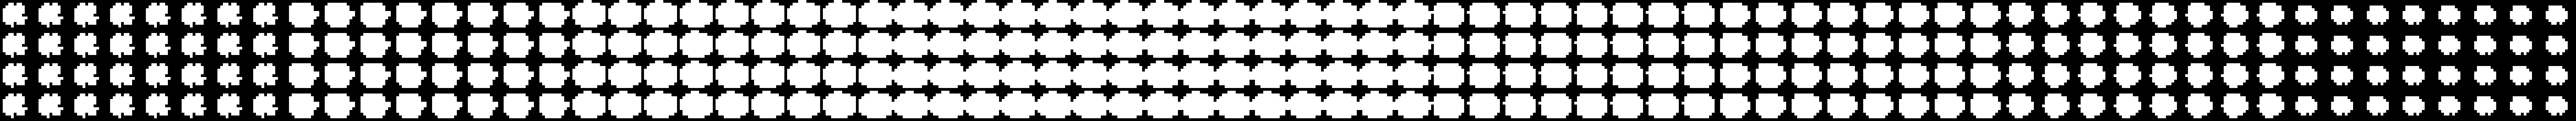


encoder func


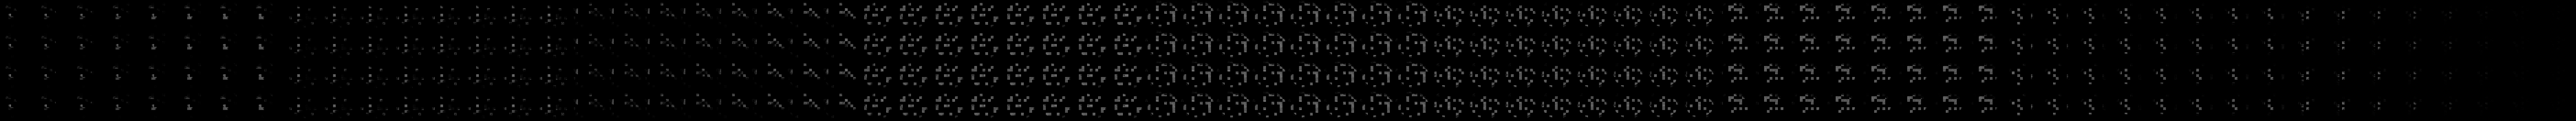


decoder func


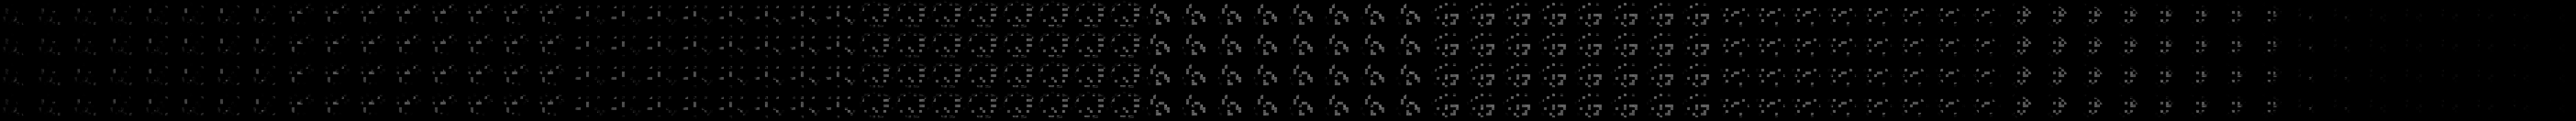

In [15]:
if utils.is_interactive():
    # extract func volumes and their reference mean and standard deviation volumes
    if masking_strategy=="MNI":
        func, _ = aug_transform(input_func)
    else:
        func, brain_pos_voxels = aug_transform(input_func)
        brain_pos_pats = model.patchify(torch.Tensor(brain_pos_voxels)[None,None,None])
        brain_pos_pats_vit = rearrange(brain_pos_pats, "b ... d -> b (...) d").mean(-1)[0]
    func = func.unsqueeze(1)  # add empty first dimension to serve as 1d channel dimension

    # patchify func samples
    print("func", func.shape)
    patches = model.patchify(func)
    print("patches", patches.shape)
    patches_vit = rearrange(patches, "b ... d -> b (...) d")
    print("patches_vit", patches_vit.shape)
    print("num patches in one timepoint", patches_vit.shape[1] // num_frames)

    # start by masking everything (aka include nothing)
    tube_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
    # approximate brain positive patches for the whole batch
    batch_positive_approx = (brain_pos_pats_vit > 0)
    mask_idx_candidates = torch.where(batch_positive_approx)[0]
    mask_idx_candidates = mask_idx_candidates[torch.randperm(len(mask_idx_candidates))]
    print("Percentage of brain positive patches", len(mask_idx_candidates) / len(batch_positive_approx))
    tube_idx = mask_idx_candidates[: int(num_patches / num_frames * (1 - tube_start_masking_ratio))]
    print("num tube patches =", len(tube_idx))
    tube_mask[tube_idx] = True  # Trues mean to include the patch, False means to remove the patch
    tube_mask = tube_mask.tile(num_frames)  # repeat masking for the other timepoints
    print("tube mask percent", tube_mask.sum().item() / len(tube_mask))

    # create decoder mask similar to tube mask, but ensure no overlap
    decoder_mask = torch.zeros(num_patches // num_frames).to(torch.bool)  # start by masking everything (aka include nothing)
    remaining_mask_idx = mask_idx_candidates[int(num_patches / num_frames * (1 - tube_start_masking_ratio)) :]  # brain positive tokens not selected for the encoder tokens
    decoder_mask_idx = remaining_mask_idx[:int(num_patches / num_frames * (1 - decoder_mask_ratio))]
    print("num decoder patches =", len(decoder_mask_idx))
    decoder_mask[decoder_mask_idx] = True
    decoder_mask = decoder_mask.tile(num_frames)  # repeat masking for the other timepoints
    print("decoder_mask percent", decoder_mask.sum().item() / len(decoder_mask))

    # apply masks to patches_vit
    tube_patches_vit = copy.deepcopy(patches_vit.detach())
    decoder_patches_vit = copy.deepcopy(patches_vit.detach())
    # tube_patches_vit[:, tube_mask] = 1
    # decoder_patches_vit[:, decoder_mask] = 1
    tube_patches_vit[:, ~tube_mask] = 0
    decoder_patches_vit[:, ~decoder_mask] = 0

    # undo patchification so we can visualize
    tube_unpatches = rearrange(
        tube_patches_vit,
        "b (f d h w) c -> b f d h w c",
        d=img_size[0]//patch_size,
        h=img_size[1]//patch_size,
        w=img_size[2]//patch_size,
    )
    decoder_unpatches = rearrange(
        decoder_patches_vit,
        "b (f d h w) c -> b f d h w c",
        d=img_size[0]//patch_size,
        h=img_size[1]//patch_size,
        w=img_size[2]//patch_size,
    )
    print("tube_unpatches", tube_unpatches.shape)
    print("decoder_unpatches", decoder_unpatches.shape)
    
    encoder_func = rearrange(
        tube_unpatches,
        "b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)",
        b=len(func),
        f=num_frames,
        d=img_size[0] // patch_size,
        h=img_size[1] // patch_size,
        w=img_size[2] // patch_size,
        pd=patch_size,
        ph=patch_size,
        pw=patch_size,
        pf=frame_patch_size,
    )
    decoder_func = rearrange(
        decoder_unpatches,
        "b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)",
        b=len(func),
        f=num_frames,
        d=img_size[0] // patch_size,
        h=img_size[1] // patch_size,
        w=img_size[2] // patch_size,
        pd=patch_size,
        ph=patch_size,
        pw=patch_size,
        pf=frame_patch_size,
    )
    print("encoder_func", encoder_func.shape)
    print("decoder_func", decoder_func.shape)
    
    brain_pos_vit = copy.deepcopy(patches_vit.detach())
    brain_pos_vit[:,batch_positive_approx.repeat(num_frames)] = 1
    brain_pos_vit[:,~batch_positive_approx.repeat(num_frames)] = 0
    brain_pos_unpatches = rearrange(
        brain_pos_vit,
        "b (f d h w) c -> b f d h w c",
        d=img_size[0]//patch_size,
        h=img_size[1]//patch_size,
        w=img_size[2]//patch_size,
    )
    brain_pos_func = rearrange(
        brain_pos_unpatches,
        "b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)",
        b=len(func),
        f=num_frames,
        d=img_size[0] // patch_size,
        h=img_size[1] // patch_size,
        w=img_size[2] // patch_size,
        pd=patch_size,
        ph=patch_size,
        pw=patch_size,
        pf=frame_patch_size,
    )

    # Visualize
    idx = 0
    print("original func")
    display(transforms.ToPILImage()(utils.reshape_to_2d(func[idx].clamp(0,1))))
    
    print("\nbrain-positive patches")
    display(transforms.ToPILImage()(utils.reshape_to_2d(brain_pos_func[idx].clamp(0,1))))

    print("\nencoder func")
    display(transforms.ToPILImage()(utils.reshape_to_2d(encoder_func[idx].clamp(0,1))))

    print("\ndecoder func")
    display(transforms.ToPILImage()(utils.reshape_to_2d(decoder_func[idx].clamp(0,1))))

# Set up optimizer and saving functions

In [16]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
opt_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)
num_iterations_per_epoch = num_samples_per_epoch // global_batch_size

total_steps = num_epochs * num_iterations_per_epoch * num_devices
print("total_steps", total_steps)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    total_steps=total_steps,
)

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 19200

Done with model preparations!
param counts:
177,336,672 total
177,336,672 trainable


In [17]:
def save_ckpt(model,tag="last"):
    ckpt_path = outdir+f'/{tag}.pth'
    torch.save(model.state_dict(), ckpt_path)
    # accelerator.save_model(model, ckpt_path, max_shard_size="2GB", safe_serialization=True)
    print(f"\n---saved {ckpt_path}!---\n")
        
def save_progress(tag="last"):
    if accelerator.is_main_process:
        ckpt_path = outdir+f'/{tag}'
        torch.save(
                {
                    "optimizer": optimizer.state_dict(),
                    "scheduler": lr_scheduler.state_dict(),
                    "epoch": epoch,
                    "recon_losses": recon_losses,
                    "contrastive_losses": contrastive_losses,
                    "lrs": lrs,
                },
                os.path.join(ckpt_path, f"params.pt"),
            )

# Start wandb (if enabled)

In [18]:
if utils.is_interactive():
    wandb_log = False
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'found'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_samples_per_epoch": num_samples_per_epoch,
      "num_iterations_per_epoch": num_iterations_per_epoch,
      "encoder_model": encoder_model,
      "decoder_model": decoder_model,
      "tube_start_masking_ratio": tube_start_masking_ratio,
      "tube_end_masking_ratio": tube_end_masking_ratio,
      "decoder_mask_ratio": decoder_mask_ratio,
      "num_frames": num_frames,
      "patch_size": patch_size,
      "frame_patch_size": frame_patch_size,
      "use_contrastive_loss": use_contrastive_loss,
      "use_cls_token": use_cls_token,
      "constrastive_loss_weight": constrastive_loss_weight,
      "num_params": num_params,
      "max_lr": max_lr,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_urls": train_urls,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

# Start training

In [19]:
epoch = 0
lrs, recon_losses, contrastive_losses, means_losses = [], [], [], []

In [20]:
# # resume from ckpt (e.g., if you are resuming from a run that got pre-empted)
# load_progress = False
# if wandb_log:
#     if wandb.run.resumed:
#         load_checkpoint_in_model(model, outdir+"/last")
#         load_progress = True
# elif resume_from_ckpt: # if resuming without using wandb
#     load_checkpoint_in_model(model, outdir+"/last")
#     load_progress = True
    
# if load_progress:
#     ckpt_path = outdir+'/last'
#     prev_params = torch.load(ckpt_path+"/params.pt")
#     optimizer.load_state_dict(prev_params["optimizer"])
#     lr_scheduler.load_state_dict(prev_params["scheduler"])
#     epoch = prev_params["epoch"]
#     recon_losses = prev_params["recon_losses"]
#     contrastive_losses = prev_params["contrastive_losses"]
#     test_losses = prev_params["test_losses"]
#     lrs = prev_params["lrs"]
#     print("Loaded model params from", ckpt_path, "at epoch", epoch)

Overall:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/127 [00:00<?, ?it/s]

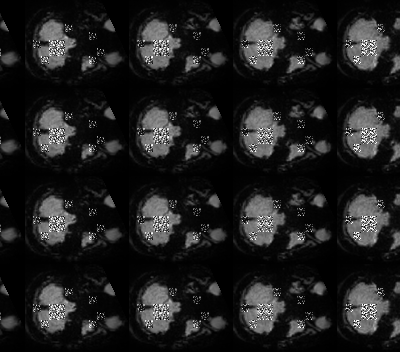

Training:   0%|          | 0/127 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
mse = nn.MSELoss()
if use_contrastive_loss:
    logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))  # learned logit scale
model.train()
progress_bar = tqdm(range(epoch, num_epochs), disable=local_rank!=0, desc="Overall")
for epoch in progress_bar:
    # get the masking ratio for the current epoch
    tube_mask_ratio = utils.get_masking_ratio(
        current_epoch=epoch, 
        total_epochs=num_epochs, 
        start_masking_ratio=tube_start_masking_ratio, 
        end_masking_ratio=tube_end_masking_ratio
    )
    with torch.cuda.amp.autocast(dtype=data_type):
        for train_i, batch in enumerate(tqdm(train_dl, disable=local_rank!=0, total=num_iterations_per_epoch-1, leave=False, desc="Training")):
            optimizer.zero_grad()

            input_func = batch['func.npy']#.clamp(0,1)

            input_session_ids = list(map(lambda x: x[0] + "_" + x[1] + "_" + x[2], zip(batch['dataset_id.txt'], batch['subject_id.txt'], batch['session_id.txt'])))
            func_ids = get_or_append_session_id(input_session_ids)

            if masking_strategy=="MNI":
                func, _ = aug_transform(input_func)
            else:
                func, brain_pos_voxels = aug_transform(input_func)
                brain_pos_pats = model.patchify(torch.Tensor(brain_pos_voxels)[None,None,None])
                brain_pos_pats_vit = rearrange(brain_pos_pats, "b ... d -> b (...) d").mean(-1)[0]
                
            if use_contrastive_loss:  # create positive pairs by duplicating the batch
                func = torch.cat([func, func], dim=0)
                meansd = torch.cat([meansd, meansd], dim=0)
                brain_pos_pats = torch.cat([brain_pos_pats, brain_pos_pats], dim=0)

            func = func.unsqueeze(1)

            # create tube mask (i.e., a mask that is the same for all frames/timepoints)
            tube_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
            batch_positive_approx = (brain_pos_pats_vit > 0)
            mask_idx_candidates = torch.where(batch_positive_approx)[0]
            mask_idx_candidates = mask_idx_candidates[torch.randperm(len(mask_idx_candidates))]
            tube_idx = mask_idx_candidates[:int(num_patches / num_frames * (1 - tube_mask_ratio))]
            tube_mask[tube_idx] = True
            tube_mask = tube_mask.tile(num_frames)

            # create decoder mask
            decoder_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
            remaining_mask_idx = mask_idx_candidates[int(num_patches / num_frames * (1 - tube_mask_ratio)):]
            decoder_mask_idx = remaining_mask_idx[:int(num_patches / num_frames * (1 - decoder_mask_ratio))]
            decoder_mask[decoder_mask_idx] = True
            decoder_mask = decoder_mask.tile(num_frames)

            # encode the tube patches
            encoder_out = model(func, id=func_ids, encoder_mask=tube_mask, device=device)
            if use_cls_token:
                enc_cls_token = encoder_out[:,:1,:]

            # decode both the encoder_out patches and masked decoder patches
            decoder_out = model(encoder_out, encoder_mask=tube_mask, decoder_mask=decoder_mask, device=device)
            # # subset only the reconstructed decoder patches
            output = decoder_out[:, -decoder_mask.sum():]

            # compare to ground truth and calculate loss
            target_patches = model.patchify(func)
            target_patches_vit = rearrange(target_patches, "b ... d -> b (...) d")
            target = target_patches_vit[:, decoder_mask].to(device)

            # add ground truth means to decoder outputs
            means_patches = target_patches.mean(1).unsqueeze(1)
            means_patches_vit = rearrange(means_patches, "b ... d -> b (...) d")
            means = means_patches_vit.tile(num_frames,1)[:, decoder_mask].to(device)
            output = output + means

            loss = mse(output, target)

            # contrastive loss
            if use_contrastive_loss:
                n_b = len(func) // 2
                cls_token1 = enc_cls_token[:n_b, 0, :]  # first half of batch, cls_token shape B, 1, d_model
                cls_token2 = enc_cls_token[n_b:, 0, :]
                contrastive_loss = utils.contrastive_loss(cls_token1, cls_token2, temperature=logit_scale)
                loss += constrastive_loss_weight * contrastive_loss
                contrastive_losses.append(contrastive_loss.item())

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            recon_losses.append(loss.item())
            means_losses.append(mse(means, target).item())
            lrs.append(optimizer.param_groups[0]["lr"])

            if train_i >= (num_iterations_per_epoch-1):
                break

        logs = {
            "train/loss": np.mean(recon_losses[-(train_i + 1) :]),
            "train/means_loss": np.mean(means_losses[-(train_i + 1) :]),
            "train/num_steps": len(recon_losses),
            "lr": np.mean(lrs[-(train_i + 1) :]),
            "epoch": epoch,
            "tube_mask_ratio": tube_mask_ratio,
            "decoder_mask_ratio": decoder_mask_ratio,
        }
        progress_bar.set_postfix(**logs)

        # Plot progress (first sample in batch)
        with torch.no_grad():
            if utils.is_interactive() or wandb_log:
                idx = 0
                if epoch % 5 == 0:
                    decode_vis = torch.zeros_like(target_patches_vit)
                    decode_vis[:, decoder_mask] = output.to(decode_vis.device).to(decode_vis.dtype)
                    decoder_unpatches = rearrange(
                        decode_vis,
                        "b (f d h w) c -> b f d h w c",
                        d=img_size[0]//patch_size,
                        h=img_size[1]//patch_size,
                        w=img_size[2]//patch_size,
                    )
                    decoder_func = rearrange(
                        decoder_unpatches,
                        "b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)",
                        b=batch_size,
                        f=num_frames,
                        d=img_size[0]//patch_size,
                        h=img_size[1]//patch_size,
                        w=img_size[2]//patch_size,
                        pd=patch_size,
                        ph=patch_size,
                        pw=patch_size,
                        pf=frame_patch_size,
                    )
                    orig_image = utils.reshape_to_2d(func[idx].clamp(0,1))
                    recon_image = utils.reshape_to_2d(decoder_func[idx].clamp(0,1))

                    combined_image = orig_image.clone()
                    combined_image[recon_image!=0] = recon_image[recon_image!=0]
                    
                    random_start = np.random.randint(recon_image.shape[1]-400)
                    orig_image = transforms.ToPILImage()(orig_image[:,random_start:random_start+400])
                    recon_image = transforms.ToPILImage()(recon_image[:,random_start:random_start+400])
                    combined_image = transforms.ToPILImage()(combined_image[:,random_start:random_start+400])

                    if wandb_log:
                        logs[f"train/orig"] = wandb.Image(orig_image, caption=f"epoch{epoch:03d}")
                        logs[f"train/recon"] = wandb.Image(recon_image, caption=f"epoch{epoch:03d}")
                        logs[f"train/combined"] = wandb.Image(combined_image, caption=f"epoch{epoch:03d}")
                    else:
                        # display(orig_image)
                        # display(recon_image)
                        display(combined_image)

        if wandb_log: wandb.log(logs)
                
        # Save model checkpoint
        if (ckpt_saving) and ((epoch % ckpt_interval == 0) or (epoch==num_epochs-1)):
            save_ckpt(model,"last")
            # save_progress()
            
        # wait for other GPUs to catch up if needed
        if distributed: torch.distributed.barrier()
        torch.cuda.empty_cache()

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(recon_losses)
plt.title("Training re-construction losses")
plt.show()
if use_contrastive_loss:
    plt.figure(figsize=(8, 3))
    plt.plot(contrastive_losses)
    plt.title("Training contrastive losses")
    plt.show()